### Dataset
Dataset was obtained from [kaggle competition - House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview) and for your convenience added to the project repository.

### Imports and settings

In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from IPython.display import display
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import BayesianRidge, Lasso, LinearRegression, Ridge
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mutual_info_score, r2_score, roc_auc_score)
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier, export_text
from tqdm.auto import tqdm
from xgboost import XGBRegressor

%matplotlib inline

In [2]:
rs = 43

### Data preparation

In [3]:
df = pd.read_csv('./data/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Exploratory data analysis (EDA)

In [4]:
# quick look at the types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
# now let's define which features we can drop
na = df.isna().sum()/len(df)
na[na > .5].sort_values(ascending=False)

PoolQC         0.995205
MiscFeature    0.963014
Alley          0.937671
Fence          0.807534
dtype: float64

In [6]:
zeroes = (df == 0).sum()/len(df)
zeroes[zeroes > .95].sort_values(ascending=False)

PoolArea        0.995205
3SsnPorch       0.983562
LowQualFinSF    0.982192
MiscVal         0.964384
dtype: float64

In [7]:
# extremely skewed distribution
skewed_columns = []
for column in df.columns:
    top1_value_ratio = df[column].value_counts(dropna=False).nlargest(1).iloc[0]/len(df)    
    if top1_value_ratio >= .99:
        print(f"{column}: {top1_value_ratio:.5f}")
        skewed_columns.append(column)

Street: 0.99589
Utilities: 0.99932
PoolArea: 0.99521
PoolQC: 0.99521


In [8]:
columns_to_drop = ["Id"]
columns_to_drop = list(set(columns_to_drop) | set(na[na > .50].axes[0]))
columns_to_drop = list(set(columns_to_drop) | set(zeroes[zeroes > .95].axes[0]))
columns_to_drop = list(set(columns_to_drop) | set(skewed_columns))
columns_to_drop.remove('3SsnPorch')
columns_to_drop

['PoolQC',
 'Id',
 'Fence',
 'MiscFeature',
 'Street',
 'MiscVal',
 'Alley',
 'Utilities',
 'LowQualFinSF',
 'PoolArea']

In [9]:
df.drop(columns=columns_to_drop, inplace=True, axis=1)

In [10]:
# let's try to automatically split features by types
columns_numerical = df.select_dtypes(include=['number']).columns.to_list()
columns_numerical_discrete   = df.select_dtypes(include=['integer']).columns.to_list()
columns_numerical_continuous = df.select_dtypes(include=['inexact']).columns.to_list()

columns_categorical = df.select_dtypes(include=['flexible', 'object', 'bool']).columns.to_list()

print(f'Numerical Columns {len(columns_numerical)}:\n{columns_numerical}', '\n')
print(f'Numerical Columns (Discrete) {len(columns_numerical_discrete)}:\n{columns_numerical_discrete}', '\n')
print(f'Numerical Columns (Continuous) {len(columns_numerical_continuous)}:\n{columns_numerical_continuous}', '\n')
print(f'Categorical Columns {len(columns_categorical)}:\n{columns_categorical}', '\n')

Numerical Columns 34:
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MoSold', 'YrSold', 'SalePrice'] 

Numerical Columns (Discrete) 31:
['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MoSold', 'YrSold', 'SalePrice'] 

Numerical Columns (Continuous) 3:
[

According to `data_description.txt` file the following columns should be categorical:
`MSSubClass, OverallQual, OverallCond`

In [11]:
# let's move it to categorical features
categorical = ["MSSubClass", "OverallQual", "OverallCond"]

columns_numerical = sorted(list(set(columns_numerical) - set(categorical) - {"SalePrice"}))
columns_categorical = sorted(list(set(columns_categorical) | set(categorical)))

print(f'Numerical Columns {len(columns_numerical)}:\n{columns_numerical}', '\n')
print(f'Categorical Columns {len(columns_categorical)}:\n{columns_categorical}', '\n')

Numerical Columns 30:
['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'MasVnrArea', 'MoSold', 'OpenPorchSF', 'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold'] 

Categorical Columns 40:
['BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'Neighborhood', 'OverallCond', 'OverallQual', 'PavedDrive', 'RoofMatl', 'RoofStyle', 'Sale

In [12]:
len(set(columns_categorical) | set(columns_numerical))

70

In [13]:
df[columns_categorical] = df[columns_categorical].astype('object')
df[columns_numerical] = df[columns_numerical].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 71 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   object 
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   float64
 4   LotShape       1460 non-null   object 
 5   LandContour    1460 non-null   object 
 6   LotConfig      1460 non-null   object 
 7   LandSlope      1460 non-null   object 
 8   Neighborhood   1460 non-null   object 
 9   Condition1     1460 non-null   object 
 10  Condition2     1460 non-null   object 
 11  BldgType       1460 non-null   object 
 12  HouseStyle     1460 non-null   object 
 13  OverallQual    1460 non-null   object 
 14  OverallCond    1460 non-null   object 
 15  YearBuilt      1460 non-null   float64
 16  YearRemodAdd   1460 non-null   float64
 17  RoofStyle      1460 non-null   object 
 18  RoofMatl

Missing values

In [14]:
columns_with_na = sorted(list(df.columns[df.isna().sum() > 0]))
columns_with_na

['BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtQual',
 'Electrical',
 'FireplaceQu',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GarageType',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'MasVnrType']

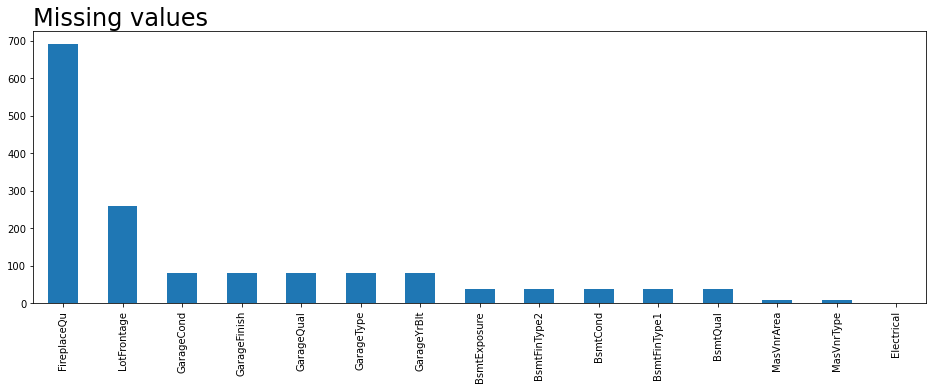

In [15]:
plt.figure(figsize = (16, 5))
plt.title("Missing values", fontdict = {'fontsize': 24}, loc = 'left')
_ = df[columns_with_na].isna().sum().sort_values(ascending=False).plot.bar()

In [16]:
for c in columns_with_na:
    print(c)
    df_group = df[c].value_counts(dropna=False).nlargest(5)
    display(df_group)
    print()
    print()

BsmtCond


TA     1311
Gd       65
Fa       45
NaN      37
Po        2
Name: BsmtCond, dtype: int64



BsmtExposure


No     953
Av     221
Gd     134
Mn     114
NaN     38
Name: BsmtExposure, dtype: int64



BsmtFinType1


Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
Name: BsmtFinType1, dtype: int64



BsmtFinType2


Unf    1256
Rec      54
LwQ      46
NaN      38
BLQ      33
Name: BsmtFinType2, dtype: int64



BsmtQual


TA     649
Gd     618
Ex     121
NaN     37
Fa      35
Name: BsmtQual, dtype: int64



Electrical


SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64



FireplaceQu


NaN    690
Gd     380
TA     313
Fa      33
Ex      24
Name: FireplaceQu, dtype: int64



GarageCond


TA     1326
NaN      81
Fa       35
Gd        9
Po        7
Name: GarageCond, dtype: int64



GarageFinish


Unf    605
RFn    422
Fin    352
NaN     81
Name: GarageFinish, dtype: int64



GarageQual


TA     1311
NaN      81
Fa       48
Gd       14
Ex        3
Name: GarageQual, dtype: int64



GarageType


Attchd     870
Detchd     387
BuiltIn     88
NaN         81
Basment     19
Name: GarageType, dtype: int64



GarageYrBlt


NaN       81
2005.0    65
2006.0    59
2004.0    53
2003.0    50
Name: GarageYrBlt, dtype: int64



LotFrontage


NaN     259
60.0    143
70.0     70
80.0     69
50.0     57
Name: LotFrontage, dtype: int64



MasVnrArea


0.0      861
NaN        8
72.0       8
108.0      8
180.0      8
Name: MasVnrArea, dtype: int64



MasVnrType


None       864
BrkFace    445
Stone      128
BrkCmn      15
NaN          8
Name: MasVnrType, dtype: int64

In [17]:
# now fill missing values taking into an account data_description.txt and values distribution
df['LotFrontage'].fillna(df['LotFrontage'].mean(), inplace = True)
df['GarageYrBlt'].fillna(df['GarageYrBlt'].mean(), inplace = True)
df['MasVnrArea'].fillna(0, inplace = True)

df['BsmtQual'].fillna('NA', inplace = True)
df['BsmtCond'].fillna('NA', inplace = True)
df['BsmtExposure'].fillna('NA', inplace = True)
df['BsmtFinType1'].fillna('NA', inplace = True)
df['BsmtFinType2'].fillna('NA', inplace = True)

df['FireplaceQu'].fillna('NA', inplace = True)

df['GarageType'].fillna('NA', inplace = True)
df['GarageFinish'].fillna('NA', inplace = True)
df['GarageQual'].fillna('NA', inplace = True)
df['GarageCond'].fillna('NA', inplace = True)

df['MasVnrType'].fillna('None', inplace = True)

df['Electrical'].fillna('SBrkr', inplace = True)

In [18]:
df[columns_with_na].isna().sum()

BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
BsmtQual        0
Electrical      0
FireplaceQu     0
GarageCond      0
GarageFinish    0
GarageQual      0
GarageType      0
GarageYrBlt     0
LotFrontage     0
MasVnrArea      0
MasVnrType      0
dtype: int64

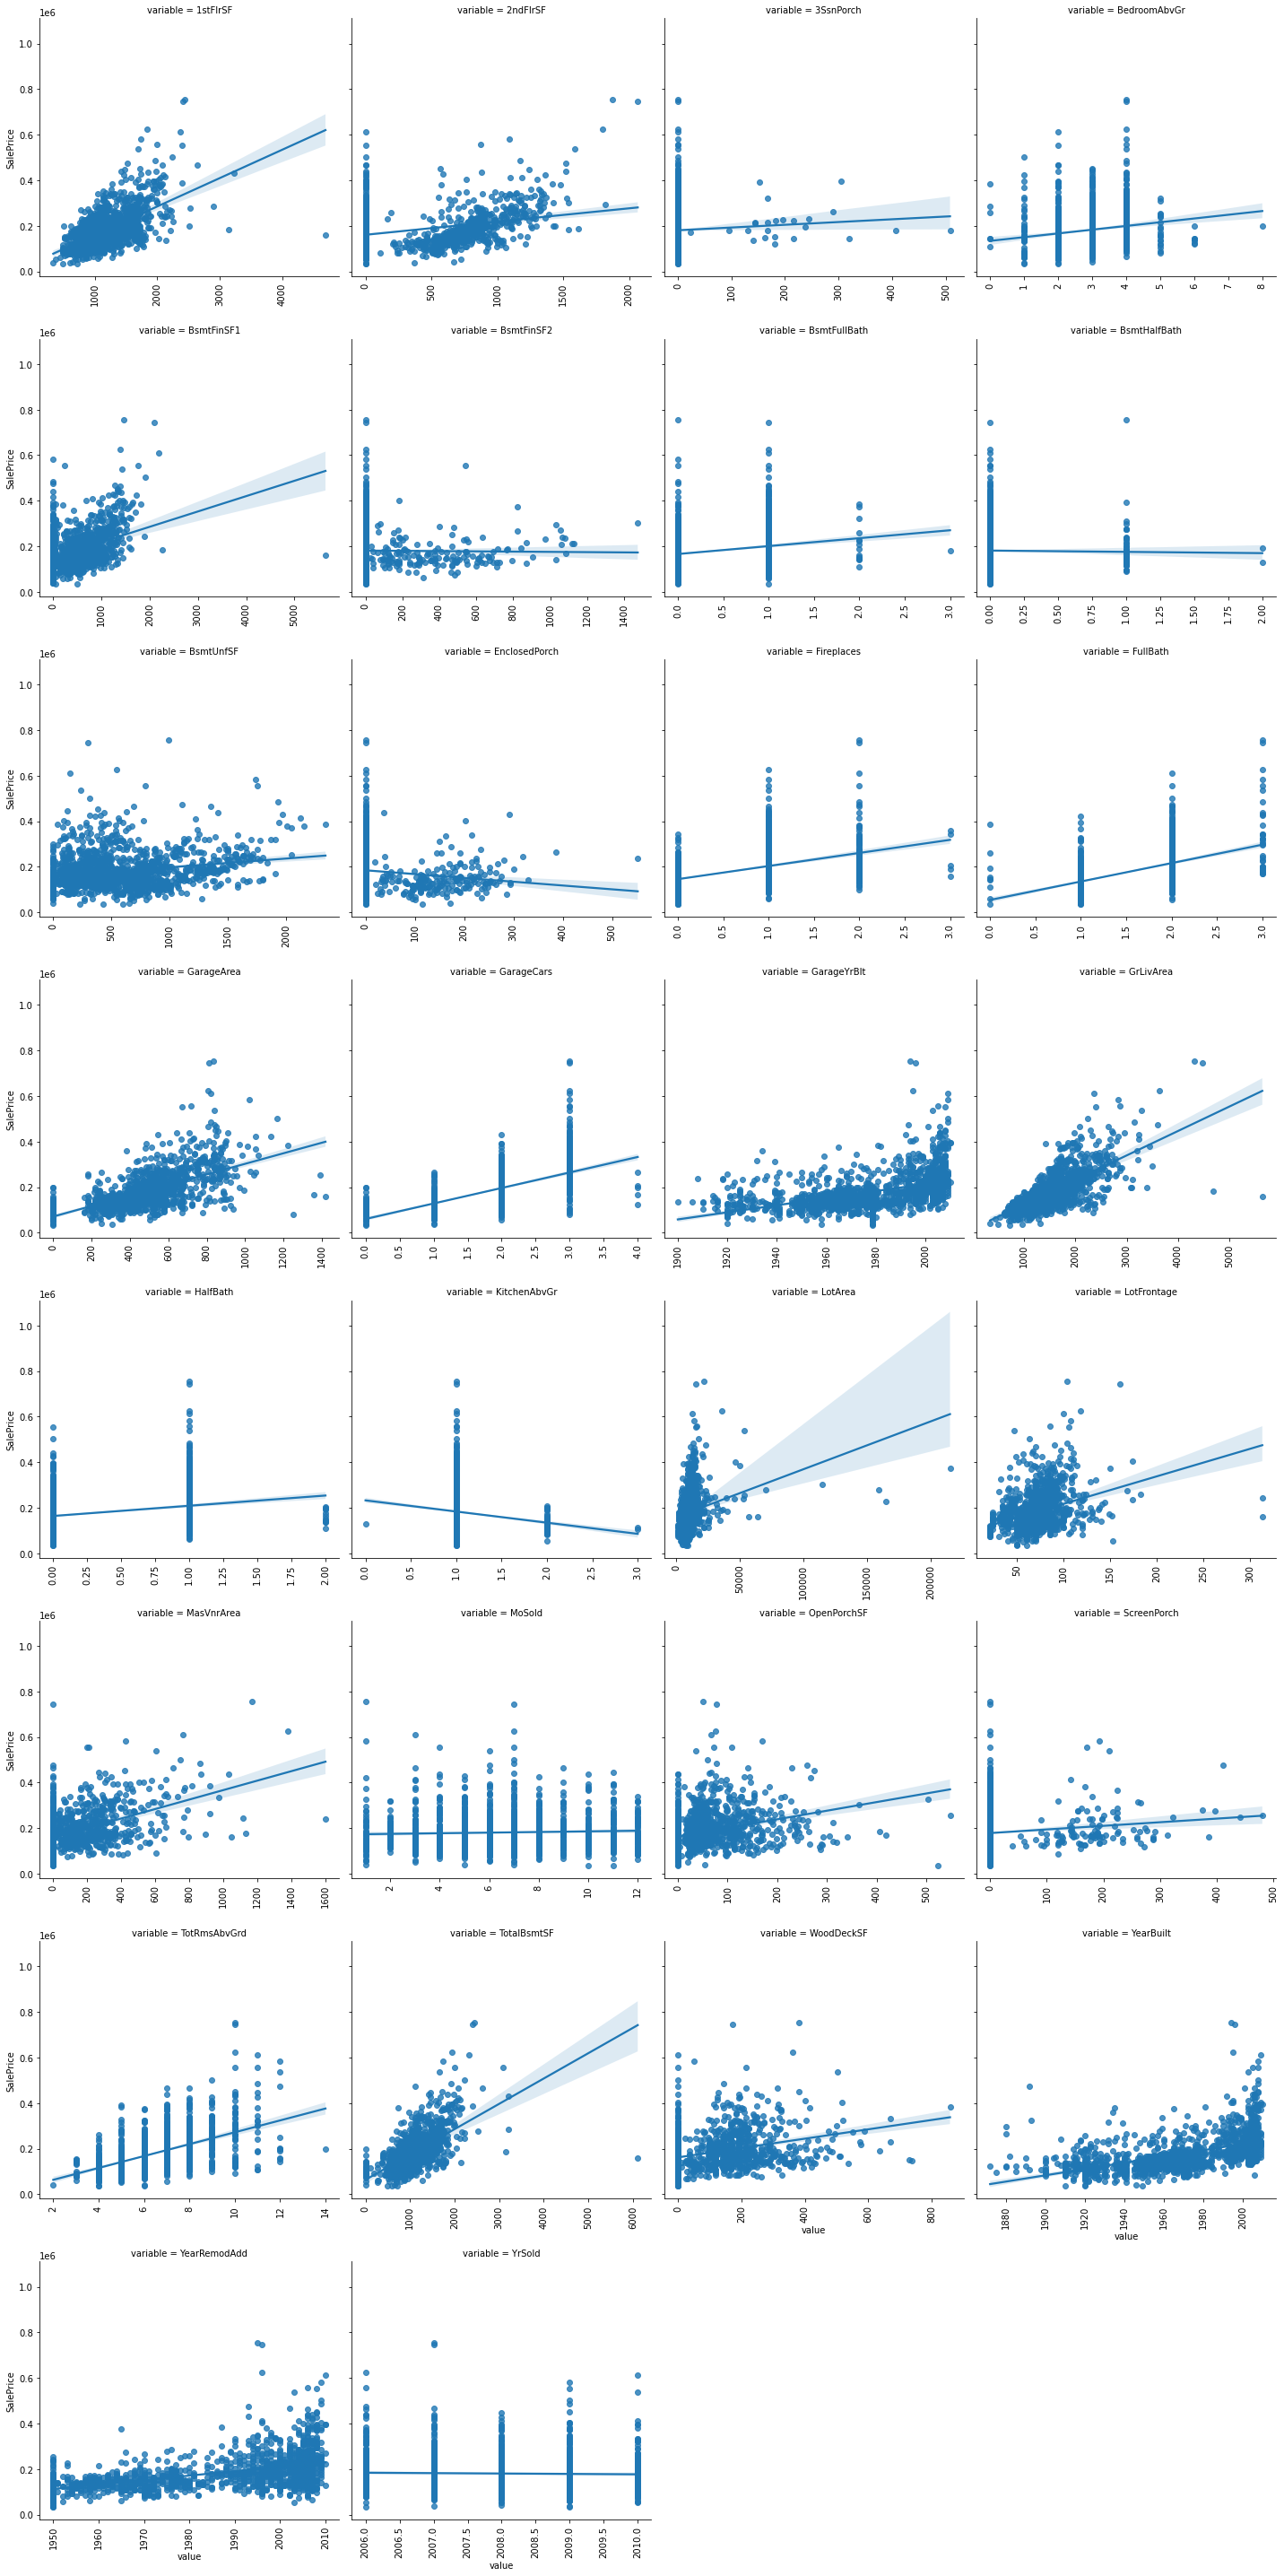

In [19]:
def scatterplot(x, y, **kwargs):
    sns.regplot(x=x, y=y)
    _ = plt.xticks(rotation=90)

f = pd.melt(df, id_vars=['SalePrice'], value_vars=columns_numerical)
g = sns.FacetGrid(f, col="variable", col_wrap=4, sharex=False, sharey=True, height=5)
g = g.map(scatterplot, "value", "SalePrice")

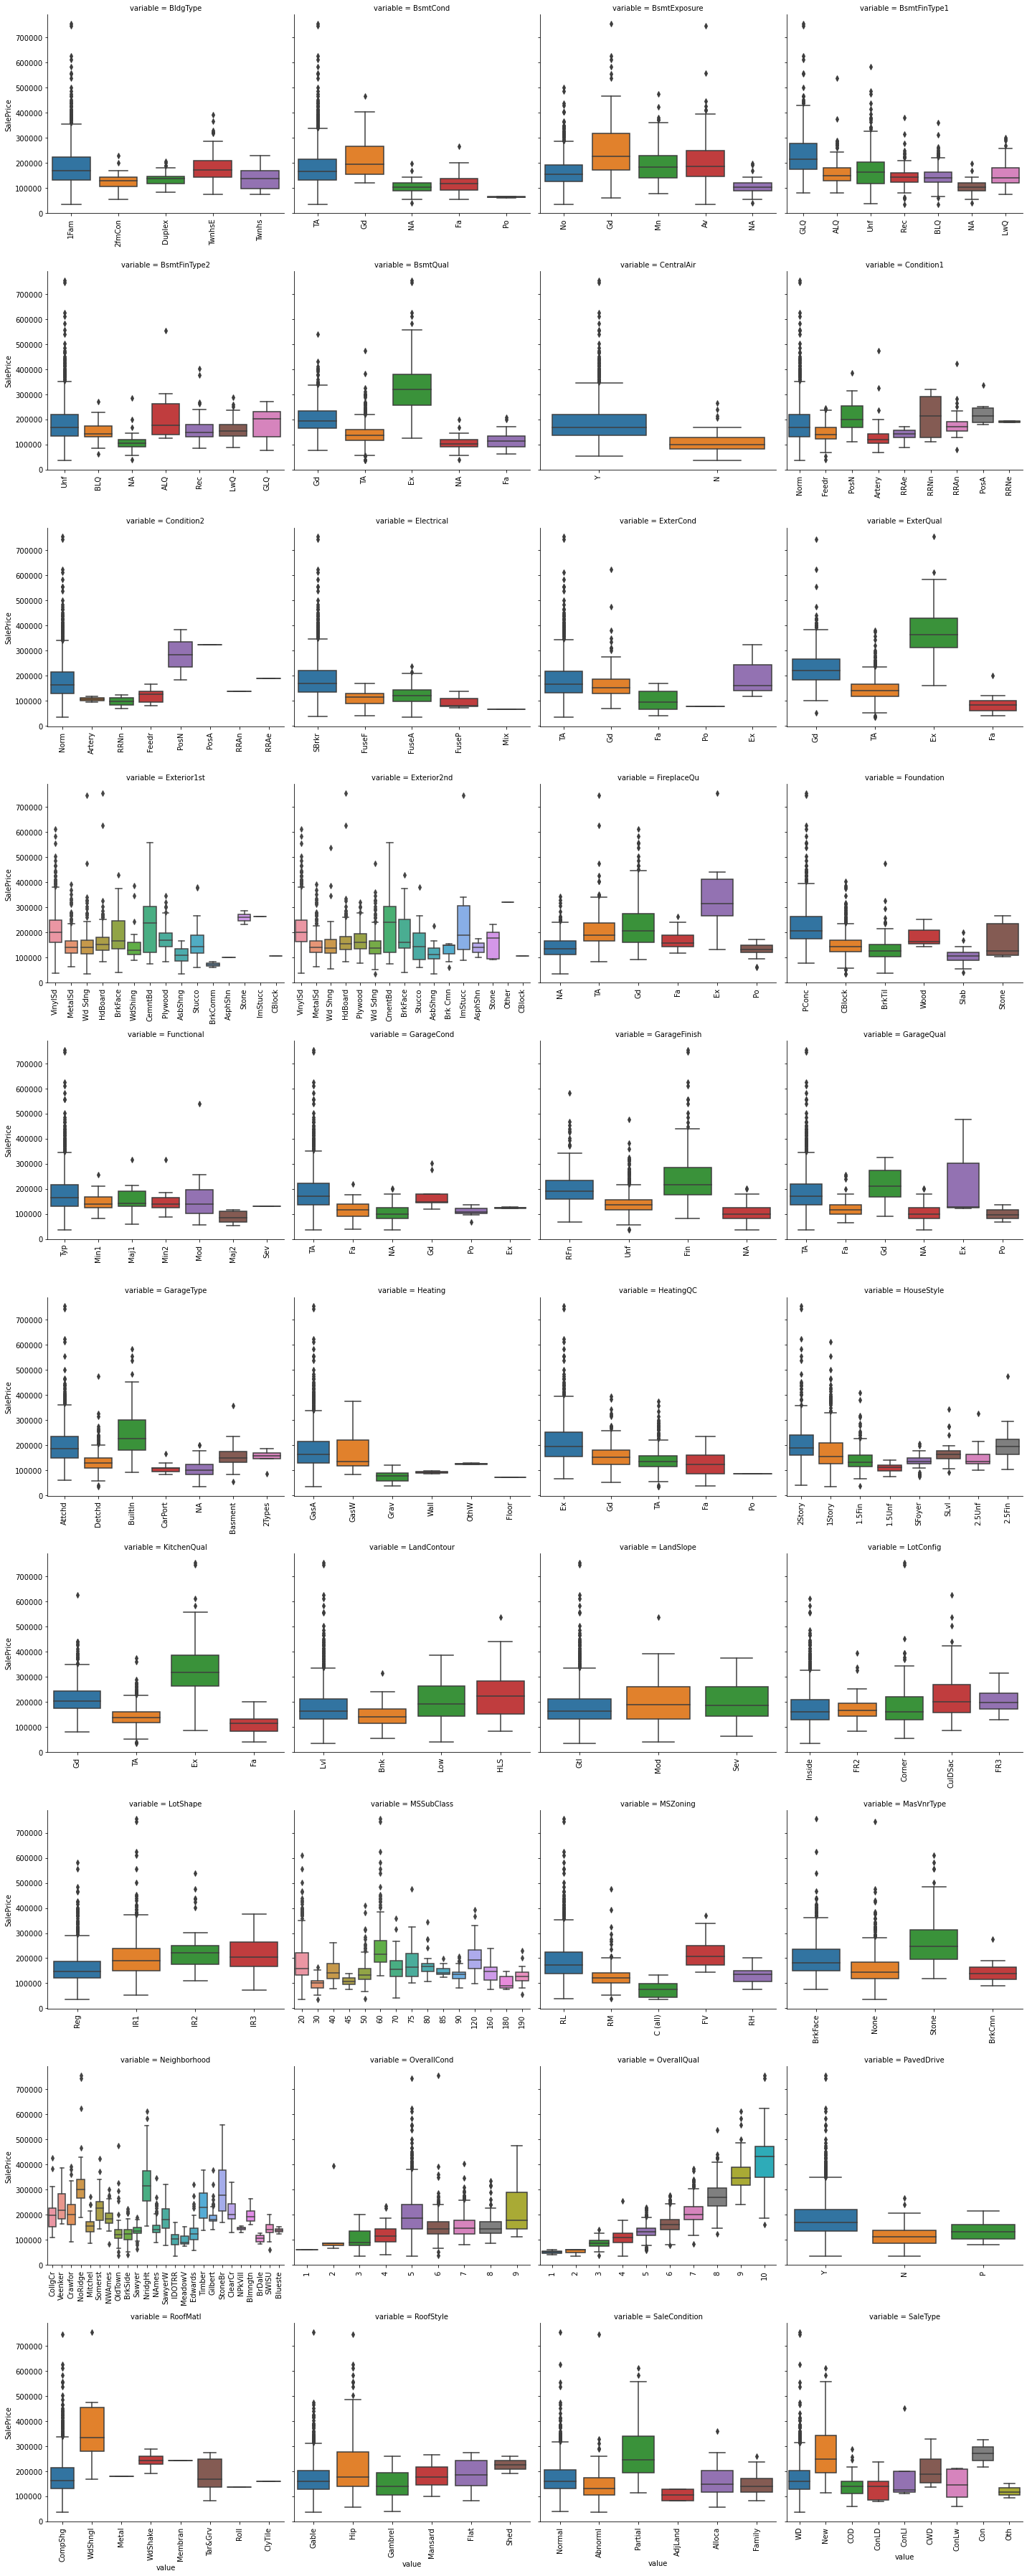

In [20]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x,y=y)
    _ = plt.xticks(rotation=90)

f = pd.melt(df, id_vars=['SalePrice'], value_vars=columns_categorical)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=True, height=5)
g = g.map(boxplot, "value", "SalePrice")

Correlation Matrix

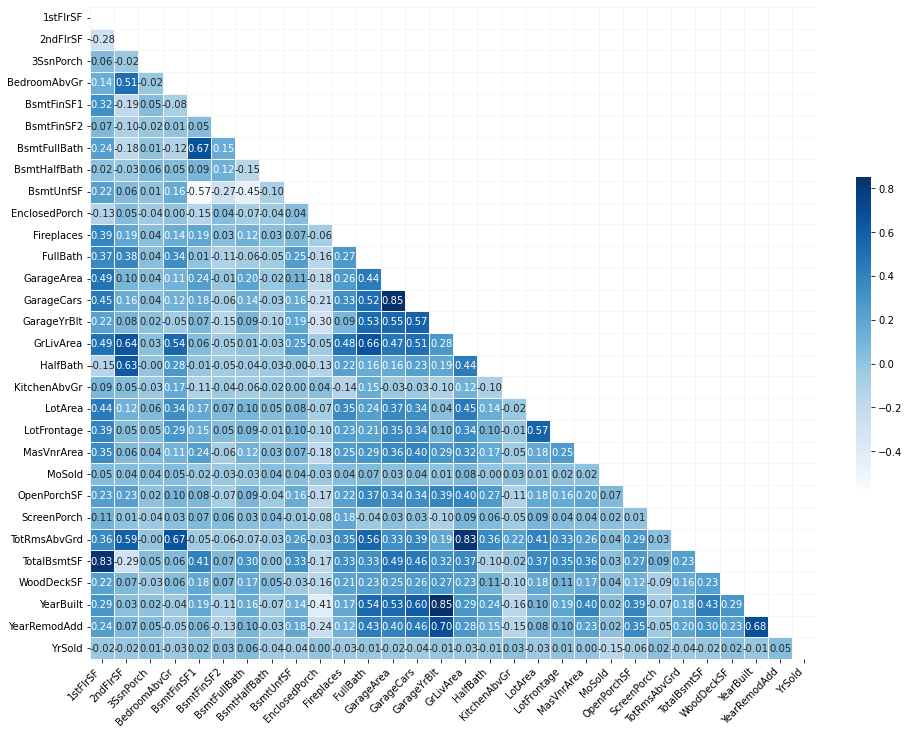

In [21]:
# plot correlation matrix
correlation = df[columns_numerical].corr(method='spearman')

# create a mask to keep only half of matrix
trimask_numerical = np.triu(np.ones_like(correlation, dtype=bool))

plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(correlation, fmt='.2f', linewidth=1, linecolor='whitesmoke', cmap='Blues', mask=trimask_numerical, annot=True, cbar_kws={'fraction' : 0.02})
_ = heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')

Mutual information

In [22]:
def mutual_info_target_score(series):
    return mutual_info_score(series, df["SalePrice"])

In [23]:
mi = df[columns_categorical].apply(mutual_info_target_score)
mi.sort_values(ascending=False)

Neighborhood     2.003888
MSSubClass       1.281812
OverallQual      1.175989
Exterior2nd      1.172542
Exterior1st      1.116941
BsmtFinType1     0.961786
FireplaceQu      0.752668
GarageFinish     0.752268
BsmtQual         0.747080
OverallCond      0.742182
HouseStyle       0.721220
KitchenQual      0.676428
GarageType       0.673624
BsmtExposure     0.666649
Foundation       0.637097
HeatingQC        0.603568
ExterQual        0.602146
MasVnrType       0.528143
LotConfig        0.472501
SaleCondition    0.466175
LotShape         0.446402
MSZoning         0.423127
SaleType         0.403521
BsmtFinType2     0.399378
Condition1       0.380689
BldgType         0.379890
RoofStyle        0.358190
BsmtCond         0.298651
GarageQual       0.288712
LandContour      0.277517
GarageCond       0.260239
ExterCond        0.237318
Functional       0.217802
Electrical       0.215779
PavedDrive       0.197437
CentralAir       0.157975
LandSlope        0.149264
Heating          0.095034
RoofMatl    

Feature engineering

In [24]:
df['Age'] = df['YrSold'] - df['YearBuilt']
df['TotalBath'] = df['FullBath'] + df['HalfBath']*.5 + df['BsmtFullBath'] + df['BsmtHalfBath']*.5
df['TotalPorch'] = df['WoodDeckSF'] + df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']

In [25]:
# Remove variables that were used to create new features
columns_to_drop = ['MoSold', 'YrSold', 'YearBuilt',
                   '1stFlrSF', '2ndFlrSF', # = GrLivArea
                   'BsmtFinSF1', 'BsmtFinSF2', # = TotalBsmtSF
                   'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath',
                   '3SsnPorch']
df.drop(columns_to_drop, axis = 1, inplace = True)

In [26]:
# prepare train/test dataframe
df_train, df_test = train_test_split(df, random_state=rs)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [27]:
# might be useful to drop, need to check
# df_train.drop(df_train[df_train["GrLivArea"] > 10000].index, inplace = True)
# df_train.drop(df_train[df_train["SalePrice"] > 250000].index, inplace = True)

In [28]:
y_train = np.log1p(df_train['SalePrice'].values)
y_test = np.log1p(df_test['SalePrice'].values)

del df_train['SalePrice']
del df_test['SalePrice']

In [29]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
test_dict = df_test.to_dict(orient='records')

X_train = dv.fit_transform(train_dict)
X_test = dv.transform(test_dict)

In [30]:
print(f'X train size: {len(X_train)} || y train size: {len(y_train)}')
print(f'X test size: {len(X_test)} || y train size: {len(y_test)}')

X train size: 1095 || y train size: 1095
X test size: 365 || y train size: 365


### Model training

In [31]:
from sklearn.pipeline import Pipeline

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor, AdaBoostRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

In [34]:
from sklearn.model_selection import cross_val_score, cross_val_predict

In [35]:
scaler = StandardScaler()
# scaler = RobustScaler()
# scaler = MinMaxScaler()

# let's test several models and find out which one or two we will optimize
pipelines = []
pipelines.append(('LASSO', Pipeline([('Scaler', scaler),('LASSO', Lasso())])))
pipelines.append(('EN', Pipeline([('Scaler', scaler),('EN', ElasticNet())])))
pipelines.append(('KNN', Pipeline([('Scaler', scaler),('KNN', KNeighborsRegressor())])))
pipelines.append(('SVR', Pipeline([('Scaler', scaler),('SVR', SVR())])))
pipelines.append(('DT', Pipeline([('Scaler', scaler),('DT', DecisionTreeRegressor())])))
pipelines.append(('ET', Pipeline([('Scaler', scaler),('ET', ExtraTreesRegressor())])))
pipelines.append(('RF', Pipeline([('Scaler', scaler),('RF', RandomForestRegressor())])))
pipelines.append(('ADAB', Pipeline([('Scaler', scaler),('ADAB', AdaBoostRegressor())])))
pipelines.append(('RIDGE', Pipeline([('Scaler', scaler),('RIDGE', Ridge())])))
pipelines.append(('XGB', Pipeline([('Scaler', scaler),('XGB', XGBRegressor())])))
pipelines.append(('GB', Pipeline([('Scaler', scaler),('GB', GradientBoostingRegressor())])))
pipelines.append(('CATB', Pipeline([('Scaler', scaler),('CATB', CatBoostRegressor(logging_level='Silent'))])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, shuffle=True, random_state=rs)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
    rf_preds = cross_val_predict(model, X_train, y_train, cv=kfold, n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    msg = "%-20s: %f (+- %f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LASSO               : -0.154420 (+- 0.028400)
EN                  : -0.154420 (+- 0.028400)
KNN                 : -0.041312 (+- 0.011684)
SVR                 : -0.037439 (+- 0.015390)
DT                  : -0.046247 (+- 0.015252)
ET                  : -0.022405 (+- 0.008488)
RF                  : -0.021733 (+- 0.008410)
ADAB                : -0.031161 (+- 0.006775)
RIDGE               : -0.025139 (+- 0.025313)
XGB                 : -0.020940 (+- 0.007980)
GB                  : -0.018346 (+- 0.008195)
CATB                : -0.015424 (+- 0.007143)


```
LASSO               : -0.160352 (0.031170)
EN                  : -0.160352 (0.031170)
KNN                 : -0.044951 (0.008000)
SVR                 : -0.041988 (0.013160)
DT                  : -0.051409 (0.010698)
ET                  : -0.026148 (0.007819)
RF                  : -0.025172 (0.006434)
ADAB                : -0.034667 (0.006435)
RIDGE               : -0.031102 (0.024983)
XGB                 : -0.026413 (0.006750)
GB                  : -0.021088 (0.006589)
CATB                : -0.018551 (0.005096)
```

As we can see `CatBoostRegressor` and `GradientBoostingRegressor` give us in this case the best result. Let's try to tune hyperparameters.

In [36]:
# prepare rescaled dataframes
scaler = StandardScaler().fit(X_train)
X_train_rescaled = scaler.transform(X_train)
X_test_rescaled = scaler.transform(X_test)

In [37]:
# GradientBoostingRegressor before optimization w/o scaler
model = GradientBoostingRegressor(random_state=rs)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = (np.sqrt(mse))
r2 = r2_score(y_test, y_pred)
print('Testing performance')
print('MSE: {:.4f}'.format(mse))
print('RMSE: {:.4f}'.format(rmse))
print('R2: {:.4f}'.format(r2))

Testing performance
MSE: 0.0173
RMSE: 0.1314
R2: 0.9014


In [38]:
# GradientBoostingRegressor before optimization w/ scaler
model = GradientBoostingRegressor(random_state=rs)
model.fit(X_train_rescaled, y_train)
y_pred = model.predict(X_test_rescaled)
mse = mean_squared_error(y_test, y_pred)
rmse = (np.sqrt(mse))
r2 = r2_score(y_test, y_pred)
print('Testing performance')
print('MSE: {:.4f}'.format(mse))
print('RMSE: {:.4f}'.format(rmse))
print('R2: {:.4f}'.format(r2))

Testing performance
MSE: 0.0172
RMSE: 0.1313
R2: 0.9015


scaler doesn't help much!

In [39]:
# # tune GradientBoostingRegressor
# from sklearn.model_selection import GridSearchCV

# best = {} # {'learning_rate': 0.08, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 400}

# param_grid = {
#               'n_estimators': [400, 500, 600, 700],
#               'max_depth': [2, 3, 4],
#               'min_samples_leaf': [2, 3, 4, 5],
#               'min_samples_split': [2, 3],
#               'learning_rate': [0.07, 0.08, 0.09]
#              }
# model = GradientBoostingRegressor(random_state=rs, **best)
# kfold = KFold(n_splits=10, shuffle=True, random_state=rs)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kfold, n_jobs=-1, verbose=2)
# grid_result = grid.fit(X_train_rescaled, y_train)

# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.017740 using {'learning_rate': 0.08, 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 700}

Best: -0.017649 using {'learning_rate': 0.08, 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 600}

Best: -0.016778 using {'learning_rate': 0.08, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}

In [40]:
best = {'learning_rate': 0.08, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 400}
model_GB = GradientBoostingRegressor(random_state=rs, **best)
model_GB.fit(X_train_rescaled, y_train)

y_pred = model_GB.predict(X_test_rescaled)
mse = mean_squared_error(y_test, y_pred)
rmse = (np.sqrt(mse))
r2 = r2_score(y_test, y_pred)
print('Testing performance')
print('MSE: {:.4f}'.format(mse))
print('RMSE: {:.4f}'.format(rmse))
print('R2: {:.4f}'.format(r2))

Testing performance
MSE: 0.0154
RMSE: 0.1243
R2: 0.9118


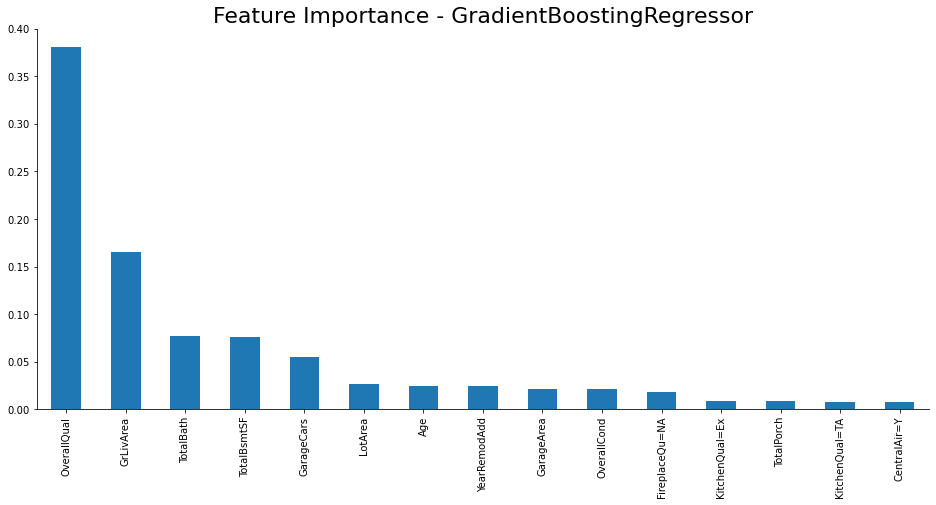

In [41]:
fi = pd.Series(model_GB.feature_importances_, index = dv.get_feature_names_out())
importances = fi.sort_values(ascending = False)
importances[:15].plot(kind = 'bar', figsize = (16, 7))
plt.title('Feature Importance - GradientBoostingRegressor', fontsize = 22)
sns.despine()
plt.show()

In [42]:
# CatBoostRegressor before optimization w/o scaler
model_CATB = CatBoostRegressor(random_state=rs, logging_level='Silent')
model_CATB.fit(X_train, y_train)

y_pred = model_CATB.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = (np.sqrt(mse))
r2 = r2_score(y_test, y_pred)
print('Testing performance')
print('MSE: {:.4f}'.format(mse))
print('RMSE: {:.4f}'.format(rmse))
print('R2: {:.4f}'.format(r2))

Testing performance
MSE: 0.0146
RMSE: 0.1207
R2: 0.9168


In [43]:
# CatBoostRegressor before optimization w scaler
model_CATB = CatBoostRegressor(random_state=rs, logging_level='Silent')
model_CATB.fit(X_train_rescaled, y_train)

y_pred = model_CATB.predict(X_test_rescaled)
mse = mean_squared_error(y_test, y_pred)
rmse = (np.sqrt(mse))
r2 = r2_score(y_test, y_pred)
print('Testing performance')
print('MSE: {:.4f}'.format(mse))
print('RMSE: {:.4f}'.format(rmse))
print('R2: {:.4f}'.format(r2))

Testing performance
MSE: 0.0146
RMSE: 0.1207
R2: 0.9168


In [44]:
from pprint import pprint
pprint(model_CATB.get_all_params())

{'auto_class_weights': 'None',
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': True,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'border_count': 254,
 'classes_count': 0,
 'depth': 6,
 'eval_metric': 'RMSE',
 'feature_border_type': 'GreedyLogSum',
 'force_unit_auto_pair_weights': False,
 'grow_policy': 'SymmetricTree',
 'iterations': 1000,
 'l2_leaf_reg': 3,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'leaf_estimation_iterations': 1,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.041533999145030975,
 'loss_function': 'RMSE',
 'max_leaves': 64,
 'min_data_in_leaf': 1,
 'model_shrink_mode': 'Constant',
 'model_shrink_rate': 0,
 'model_size_reg': 0.5,
 'nan_mode': 'Min',
 'penalties_coefficient': 1,
 'pool_metainfo_options': {'tags': {}},
 'posterior_sampling': False,
 'random_seed': 43,
 'random_strength': 1,
 'rsm': 1,
 'sampling_frequency': 'PerTree',
 'score_function': 'Cosine',
 'sparse_features_conflict_frac

In [48]:
# # CatBoostRegressor optimization
# model = CatBoostRegressor(random_state=rs, logging_level='Silent')

# grid = {
#          'learning_rate': [0.02, 0.03, 0.04],
#          'depth': [1, 2, 3],
#          'l2_leaf_reg': [1, 2]
#        }

# grid_search_result = model.grid_search(grid, X=X_train, y=y_train, plot=True)

In [49]:
# pprint(model.get_all_params())

In [50]:
best = {'l2_leaf_reg': 1, 'depth': 5}
model_CATB = CatBoostRegressor(random_state=rs, logging_level='Silent', **best)
model_CATB.fit(X_train_rescaled, y_train)

y_pred = model_CATB.predict(X_test_rescaled)
mse = mean_squared_error(y_test, y_pred)
rmse = (np.sqrt(mse))
r2 = r2_score(y_test, y_pred)
print('Testing performance')
print('MSE: {:.4f}'.format(mse))
print('RMSE: {:.4f}'.format(rmse))
print('R2: {:.4f}'.format(r2))

Testing performance
MSE: 0.0140
RMSE: 0.1183
R2: 0.9201


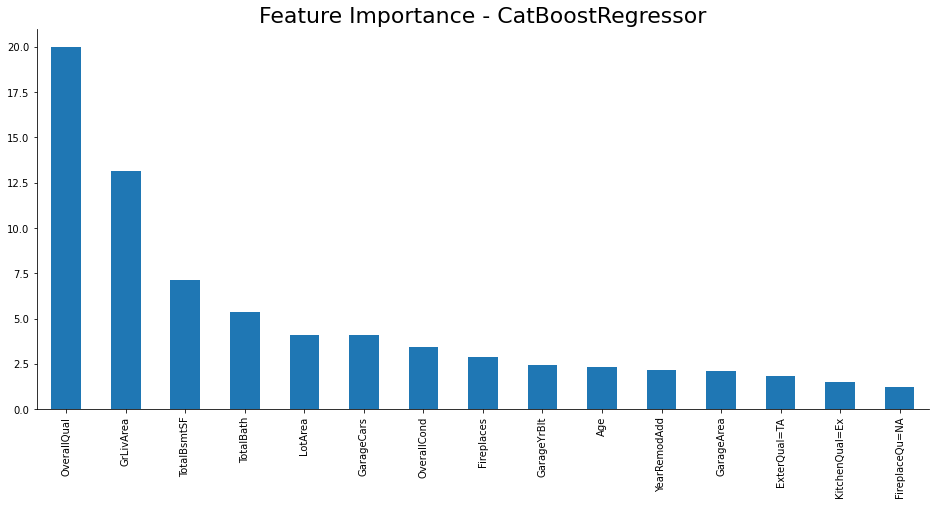

In [51]:
fi = pd.Series(model_CATB.feature_importances_, index = dv.get_feature_names_out())
importances = fi.sort_values(ascending = False)
importances[:15].plot(kind = 'bar', figsize = (16, 7))
plt.title('Feature Importance - CatBoostRegressor', fontsize = 22)
sns.despine()
plt.show()

```
Testing performance - GradientBoostingRegressor
MSE: 0.0154
RMSE: 0.1243
R2: 0.9118
    
Testing performance - CatBoostRegressor
MSE: 0.0140
RMSE: 0.1183
R2: 0.9201
```

CatBoostRegressor give better results, will use it in production